In [1]:
import pickle
from tkinter import filedialog, messagebox
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


def carregar_modelo(nome_arquivo):
    try:
        with open(nome_arquivo, 'rb') as arquivo:
            model = pickle.load(arquivo)
        print(f"Modelo carregado com sucesso de {nome_arquivo}.")
        return model
    except FileNotFoundError:
        print(f"Erro: O arquivo {nome_arquivo} não foi encontrado.")
        return None
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        return None

In [2]:
# def analyse_archive(model, df):
#     best_pgns = []
# 
#     for pgn in df['pgn'].unique():  # Assumindo que 'pgn' é uma coluna que identifica cada sequência
#         df_pgn = df[df['pgn'] == pgn].copy()  # Filtra o DataFrame para o pgn atual
#         print(df_pgn.head())
#         for i in range(8):  # Assumindo que cada dado tem 8 bytes
#             byte_column = f'byte_{i}'
# 
#             # Transformar a coluna de bytes em lista
#             df_pgn[byte_column] = df_pgn['x'].apply(lambda x: int(x[i], 16))
# 
#             # Obter valores de byte e processá-los
#             X = df_pgn[byte_column].values
#             if len(X) > 1:  # Garantir que temos dados suficientes e mais de uma classe
#                 # Treinar o modelo para este byte específico
#                 y_pred = model.predict(X)
#                 # Armazenar os melhores pgns
#                 best_pgns.append((pgn, i, y_pred))
# 
#     return best_pgns



In [3]:
def process_data(hex_data):
    # Verifica se a entrada é uma string
    if isinstance(hex_data, str):
        byte_list = hex_data.split(' ')

        # Verifica se a lista contém exatamente 8 itens
        if len(byte_list) < 8:
            byte_list.extend(['00'] * (8 - len(byte_list)))

        # Converte os valores de hexadecimal para decimal
        byte_list = [int(byte, 16) for byte in byte_list]

        # Converte a lista em um DataFrame com uma linha e 8 colunas
        df = pd.DataFrame([byte_list])

        return byte_list  # Retorna a lista para ser expandida em colunas
    else:
        raise ValueError("A entrada deve ser uma string hexadecimal.")


In [4]:
def fileToDataframe(file_path):
    df = pd.read_csv(file_path, sep=';', quotechar='"', skiprows=6)
    df = df.dropna(subset=['Data (hex)'])
    df['Identifier (hex)'] = df['Identifier (hex)'].apply(lambda x: int(x, 16))

    byte_columns = df['Data (hex)'].apply(process_data)
    
    byte_columns = pd.DataFrame(byte_columns.tolist(), index=df.index, columns=[f'byte_{i + 1}' for i in range(8)])
    print(byte_columns)
    columns_to_drop = ['Format', 'Flags', 'Time', 'Data (hex)']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    df = pd.concat([df, byte_columns], axis=1)
    df = df.rename(columns={'Identifier (hex)': 'pgn'})
    return df

In [5]:
def ui_load_ixxt_archive(file_path):
    # Se o caminho não for fornecido, abrir a caixa de diálogo para selecionar o arquivo
    if not file_path:
        file_path = filedialog.askopenfilename(
            title="Selecione o arquivo CSV",
            filetypes=(("CSV files", "*.CSV"), ("all files", "*.*"))
        )
    
    # Verificar se o caminho foi fornecido ou selecionado
    if file_path:
        df = fileToDataframe(file_path)  # Simulação do carregamento de dados
        return df
    else:
        print("Nenhum arquivo foi selecionado.")
        return None

In [6]:
def filtrar_dataframe(df, pgn, byte):

    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return None

    if pgn and byte:
        try:
            filtered_df = df[df['pgn'] == int(pgn, 16)]  # Se pgn for uma string hexadecimal

            # Verificar se o byte filtrado existe
            if byte in filtered_df.columns:
                # Filtrar os valores do byte especificado que não são 'FF' (255 em decimal)
                filtered_df = filtered_df[[byte]]
                filtered_df = filtered_df[filtered_df[byte] != 255]
                filtered_df = filtered_df.rename(columns={byte: 'x'})

                if not filtered_df.empty:
                    return filtered_df
                else:
                    messagebox.showinfo("Informação", "Nenhum valor diferente de FF encontrado após filtrar.")
                    return None
            else:
                messagebox.showinfo("Informação", f"A coluna {byte} não existe.")
                return None
        except Exception as e:
            messagebox.showerror("Erro", f"Erro ao aplicar filtros: {str(e)}")
            return None
    else:
        messagebox.showwarning("Aviso", "Preencha os campos de filtro antes de filtrar.")
        return None

In [7]:
# Função para verificar se uma coluna tem valores constantes
def coluna_eh_constante(coluna):
    return len(np.unique(coluna)) == 1

# Função para filtrar os dados pelo PGN e fazer as predições
def analyse_archive(model, df):
    best_pgns = []

    # Exibir as primeiras linhas do DataFrame para verificar a estrutura
    print("Primeiras linhas do DataFrame:")
    print(df.head())

    # Iterar sobre cada PGN único no DataFrame
    for pgn in df['pgn'].unique():
        df_pgn = df[df['pgn'] == pgn].copy()  # Filtrar o DataFrame para o PGN atual
        
        print(f"\nAnalisando PGN: {pgn}")
        print("Primeiras linhas do DataFrame para este PGN:")
        print(df_pgn.head())  # Exibir o DataFrame filtrado por PGN

        # Criar uma lista para armazenar os bytes como arrays
        byte_arrays = []
        
        # Iterar sobre as colunas de bytes (de 'byte_1' até 'byte_8')
        for i in range(1, 9):  # Para os bytes de 1 a 8
            byte_column = f'byte_{i}'  # Supondo que os bytes estão nomeados como byte_1, byte_2, ..., byte_8
            
            # Verificar se a coluna tem valores constantes e descartar se tiver
            if coluna_eh_constante(df_pgn[byte_column]):
                print(f"{byte_column} descartada por ser constante.")
                continue
            
            print(f"Processando {byte_column}")
            
            # Obter os valores de cada byte e adicionar ao array
            X = df_pgn[byte_column].values
            print(f"Valores de {byte_column}: {X[:100]}")  # Exibir os primeiros 5 valores da coluna
            
            if len(X) > 1:  # Garantir que temos dados suficientes
                byte_arrays.append(X)
        
        # Converter os bytes para um formato que o modelo pode usar (array 2D)
        if byte_arrays:  # Garantir que há bytes para processar
            byte_array = np.array(byte_arrays).T  # Transpor para ajustar a forma correta (cada linha é uma sequência de bytes)
        
            print("Matriz de bytes para predição:")
            print(byte_array[:10, :])  # Mostrar as primeiras 5 sequências de bytes para o modelo
        
            # Fazer predições para as sequências de bytes
            y_pred = model.predict(byte_array)
            
            print(f"Predições para PGN {pgn}: {y_pred[:5]}")  # Exibir as primeiras 5 predições
            
            # Armazenar os melhores PGNs com base nas predições (exemplo: guardar os PGNs com predições positivas)
            if np.any(y_pred > 0.95):  # Exemplo: considera PGNs onde há predição positiva
                best_pgns.append((pgn, y_pred))
    
    print("\nMelhores PGNs (com predição positiva):")
    print(best_pgns)  # Exibir os melhores PGNs e suas predições
    
    return best_pgns


In [13]:
df = ui_load_ixxt_archive('C:\Repositórios\CANProtocolMLScanner\JUMPY 2024\limpador_vel1_5x_jumpy.CSV') 

model = carregar_modelo("meu_modelo.pkl")

best_pgns = analyse_archive(model, df)

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\user\AppData\Local\Temp\ipykernel_15112\1886982084.py:1: SyntaxWarning: invalid escape sequence '\R'
  df = ui_load_ixxt_archive('C:\Repositórios\CANProtocolMLScanner\JUMPY 2024\limpador_vel1_5x_jumpy.CSV')


       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0          93       0       0       0       0       0       0       0
1           0       0       0       0     175     215      70       0
2           0       0       0       0       0       0       0       0
3         255     195       0       7     196       0      32       0
4          25     168      49       0      76      50      49      49
...       ...     ...     ...     ...     ...     ...     ...     ...
16069     127     192       1       0     128       0       0       0
16070      25     128      47       0      76      50      47      47
16071      47      48       0     138       0     161      32       0
16072      50       0     240       0       0       0       0       0
16073     255     195       0       7     110       0      32       0

[16074 rows x 8 columns]
Erro ao carregar o modelo: No module named 'keras'
Primeiras linhas do DataFrame:
    pgn  byte_1  byte_2  byte_3  byte_4  byte_5  byt

C:\Users\user\AppData\Local\Temp\ipykernel_15112\1886982084.py:1: SyntaxWarning: invalid escape sequence '\R'
  df = ui_load_ixxt_archive('C:\Repositórios\CANProtocolMLScanner\JUMPY 2024\limpador_vel1_5x_jumpy.CSV')


AttributeError: 'NoneType' object has no attribute 'predict'

In [105]:
def plot_best_pgns(best_pgns):
    """
    Plota as melhores sequências de PGNs recebidas.

    Args:
        best_pgns (list): Lista contendo tuplas de PGNs e arrays com as respectivas sequências.
    """
    for pgn, sequence in best_pgns:
        plt.figure(figsize=(10, 6))
        plt.plot(sequence, label=f"PGN {pgn}")
        plt.xlabel('Timestep')
        plt.ylabel('Valor')
        plt.title(f"Melhor sequência para PGN {pgn}")
        plt.legend()
        plt.show()

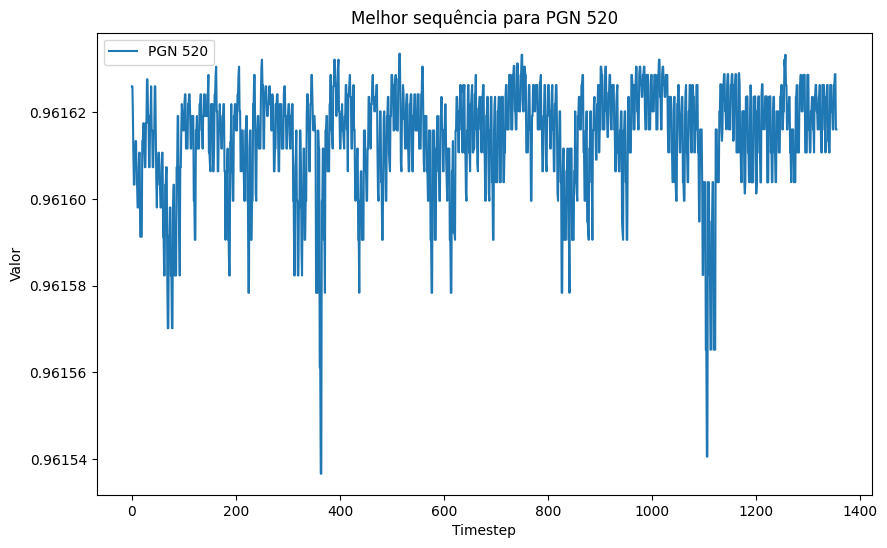

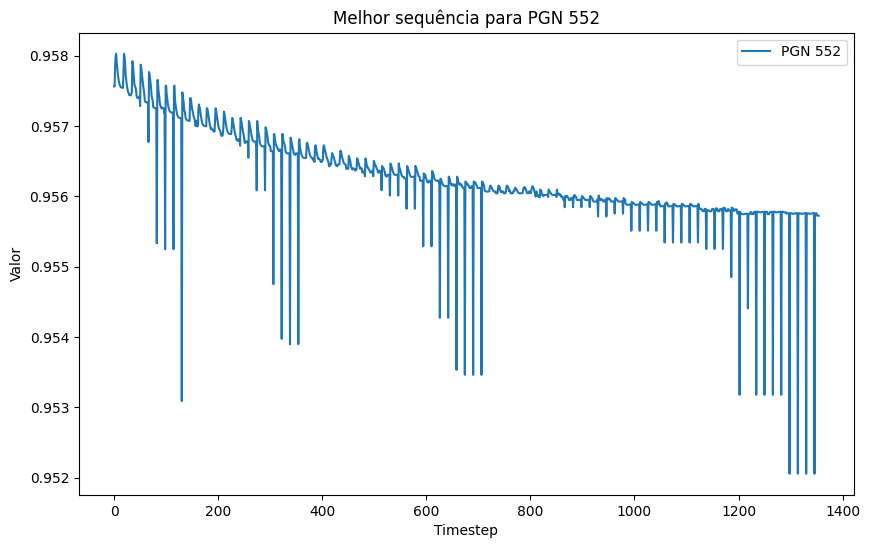

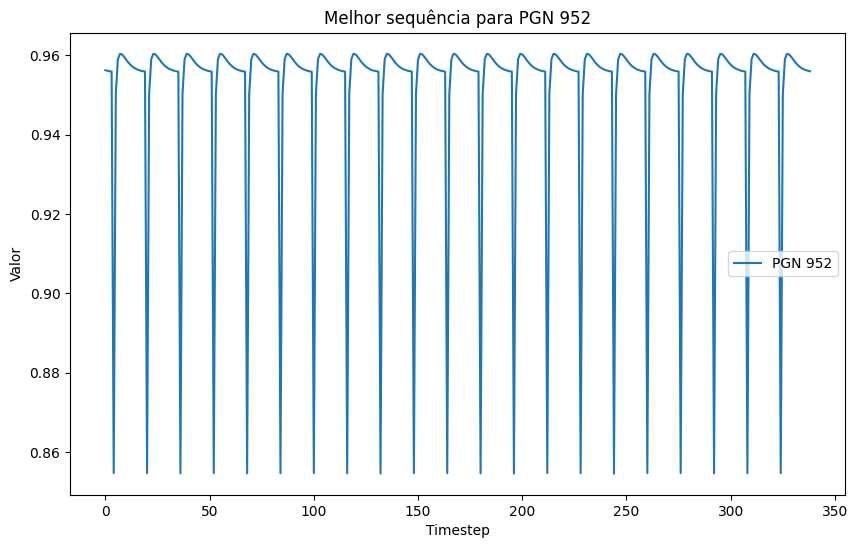

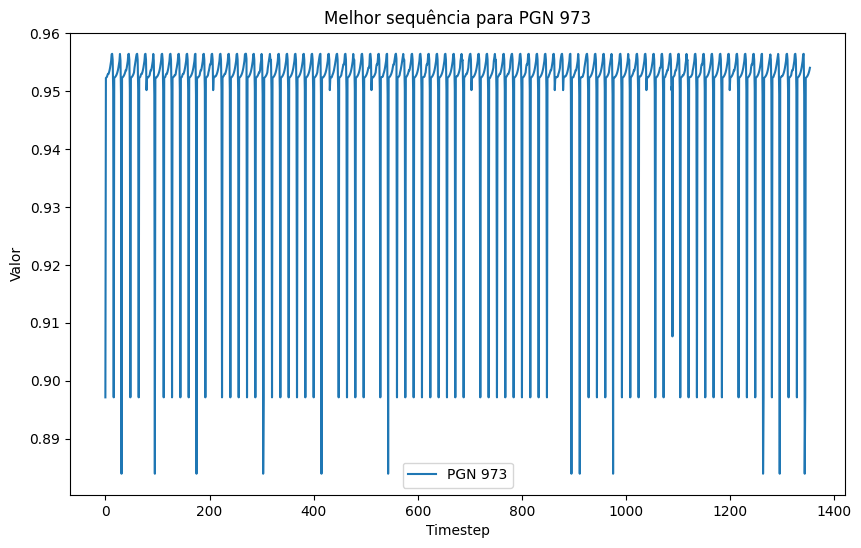

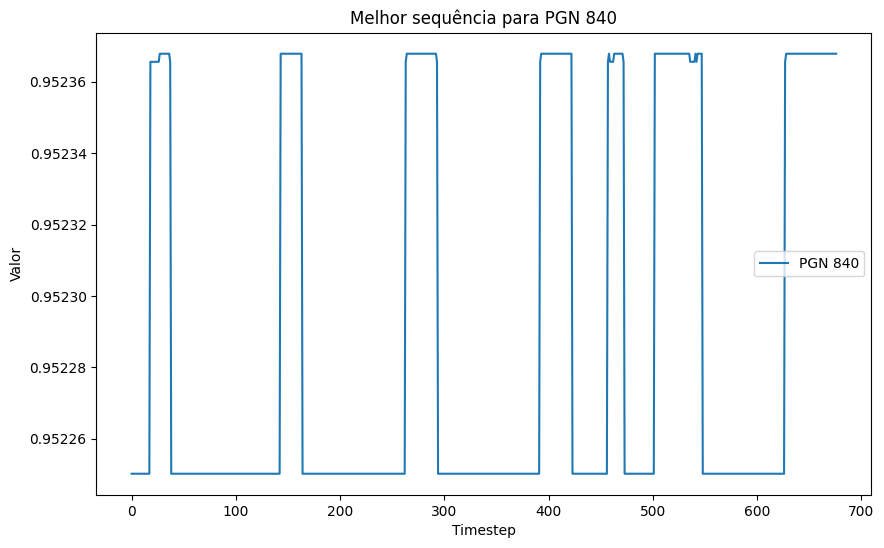

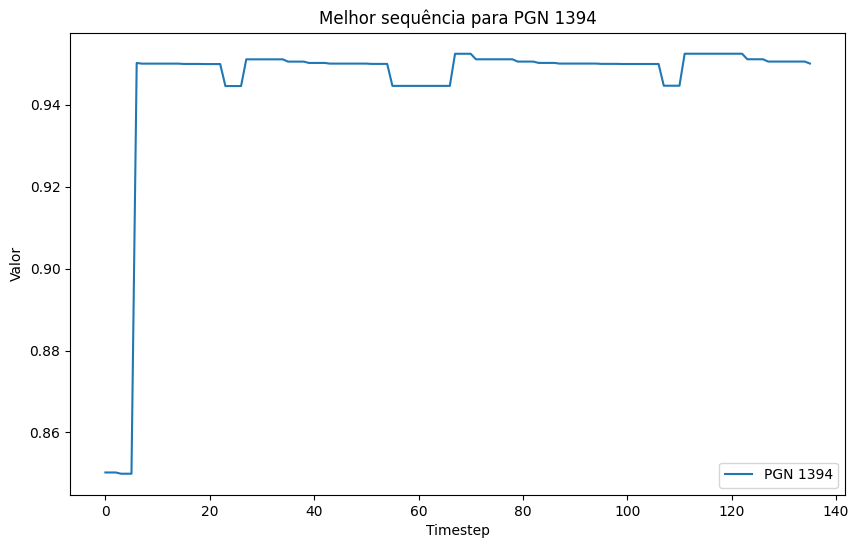

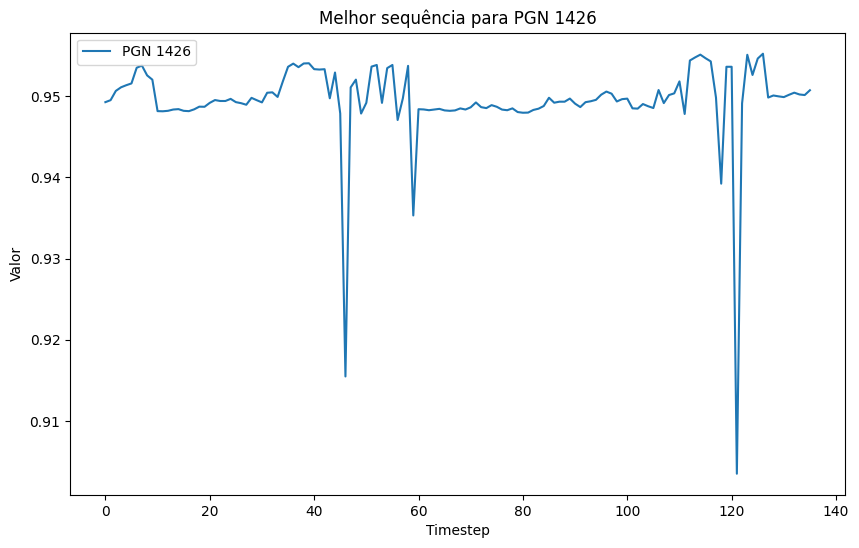

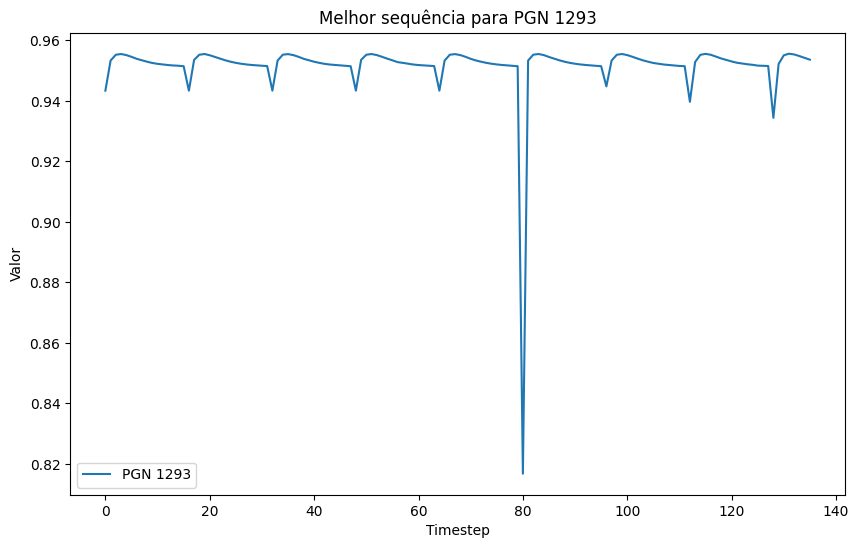

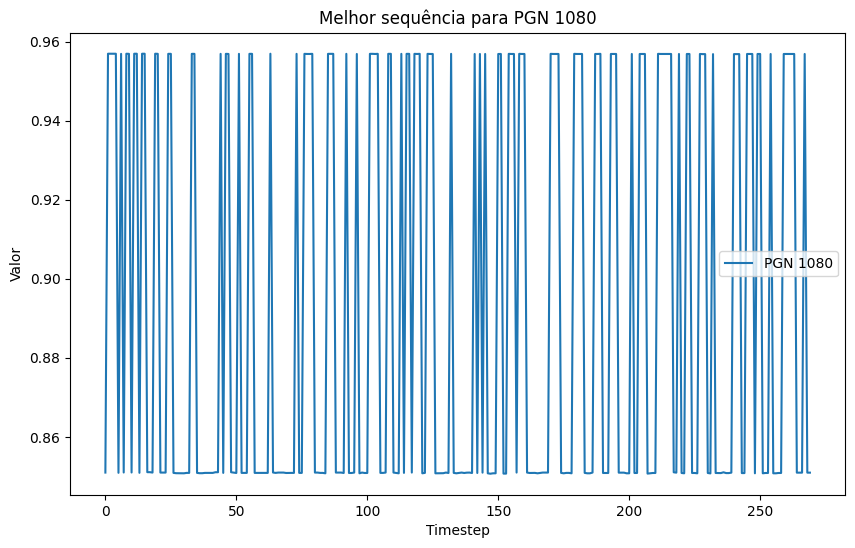

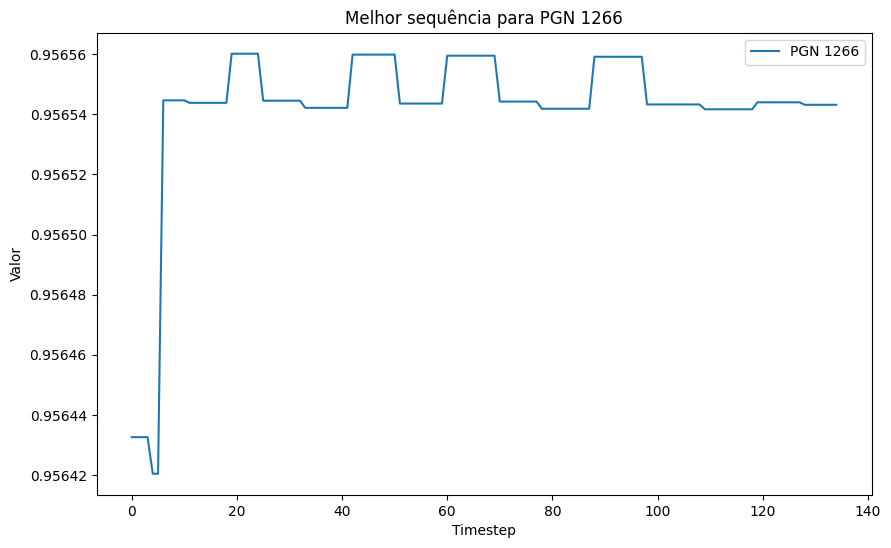

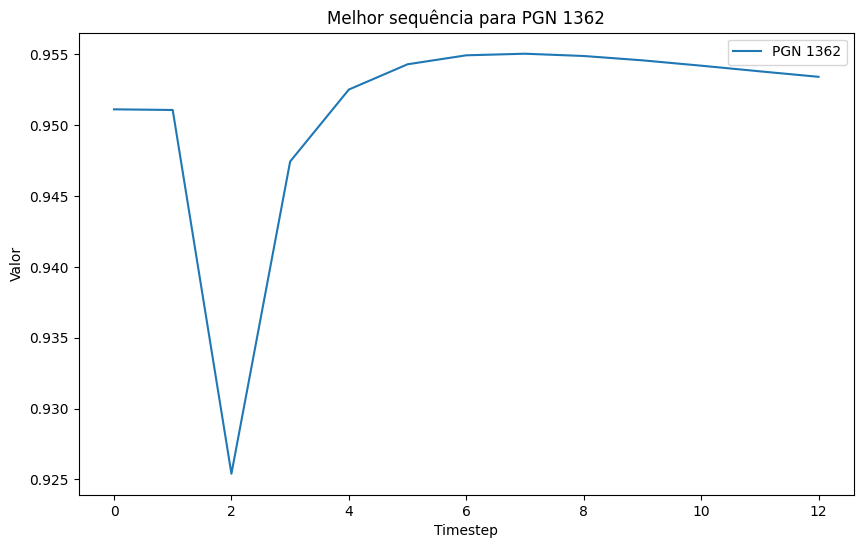

In [106]:
plot_best_pgns(best_pgns)
